# Forecasting Taxi Demands

<div style="background-color: rgb(33,150,243); padding: 15px; border-radius: 5px;">
This notebook is dedicated to forecasting. It loads a trained model, processes new data with temporal and lagged features, and generates demand forecasts, displaying results in time-series plots.
The best-performing model is used to forecast hourly demand for the Bronx for the first week of September 2024. The notebook also includes an analysis to determine the optimal number of taxis needed to meet this demand, factoring in assumptions like average trip duration and operational constraints. 
</div>

## Libraries

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
import math

## Helper Functions

In [2]:
def sin_transform(x, period):
    """
    Sine transformation
    """
    return np.sin(x / period * 2 * np.pi)

In [3]:
def cos_transform(x, period):
    """
    Cosine transformation
    """
    return np.cos(x / period * 2 * np.pi)

In [4]:
def load_model(filename="../models/best_model.joblib"):
    """
    Loads the saved model
    """
    model = joblib.load(filename)
    print("Model loaded successfully")
    return model

In [5]:
def get_time_of_day(hour):
    """
    Helps to create time based feature
    """
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

In [6]:
def add_lagged_features(row, historic_df):
    """
    Adds lag and ewma features being used in the model
    """
    row = row.copy()
    last_12_hours = historic_df['demand_count'].iloc[-12:]
    row['lag_6h'] = last_12_hours.iloc[-6] if len(last_12_hours) >= 6 else None
    row['lag_12h'] = last_12_hours.iloc[-12] if len(last_12_hours) >= 12 else None
    row['ewma_3h'] = last_12_hours.ewm(span=3, adjust=False).mean().iloc[-1]
    row['ewma_6h'] = last_12_hours.ewm(span=6, adjust=False).mean().iloc[-1]
    row['ewma_12h'] = last_12_hours.ewm(span=12, adjust=False).mean().iloc[-1]
    return row

In [7]:
def forecast_demand(new_row, historic_df, model):
    """
    Invokes the model for forecasting
    """
    prepared_row = prepare_features(new_row, historic_df)
    predicted_demand = model.predict(prepared_row)[0]
    return new_row['time'], predicted_demand

In [8]:
def prepare_features(new_row, historic_df):
    """
    Calculates features for any new row of data for which demand has to be calcualted
    """
    new_row = new_row.copy()
    if not pd.api.types.is_datetime64_any_dtype(new_row['time']):
        new_row['time'] = pd.to_datetime(new_row['time'])
    new_row_df = pd.DataFrame([new_row])

    new_row_df = add_temporal_features(new_row_df)

    for col in ['hour', 'day_of_week', 'day_of_month', 'month', 'lag_12h', 'ewma_3h', 'ewma_6h']:
        if col in new_row_df.columns:
            new_row_df[col] = pd.to_numeric(new_row_df[col], errors='coerce')
    
    new_row_with_lags = add_lagged_features(new_row_df.iloc[0], historic_df)
    
    return pd.DataFrame([new_row_with_lags])

In [9]:
def add_temporal_features(df):
    """
    Adds temporal features extracted from time of the pick-up
    """
    df = df.copy()
    df['hour'] = df['time'].dt.hour
    df['time_of_day'] = df['hour'].apply(get_time_of_day)
    df['time_of_day'] = pd.Categorical(
        df['time_of_day'],
        categories=['Morning', 'Afternoon', 'Evening', 'Night'],
        ordered=True
    )
    df['day_of_week'] = df['time'].dt.strftime('%w')
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in ["Saturday", "Sunday"] else 0).astype('category')
    df['day_of_month'] = df['time'].dt.day
    df['month'] = df['time'].dt.strftime('%m')
    return df

## Loading Best Model

In [10]:
loaded_model = load_model()

Model loaded successfully


In [11]:
loaded_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('functiontransformer-1',
                                                  FunctionTransformer(func=<function sin_transform at 0x107d2e560>,
                                                                      kw_args={'period': 12}),
                                                  ['month']),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function cos_transform at 0x14d945120>,
                                                                      kw_args={'period': 12}),
                                                  ['month']),
                                                 ('functi...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=50, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

## Data generation

In [12]:
new_df = pd.read_csv('../data/clean/synthesized_data.csv', parse_dates=['time'])

In [13]:
new_df.head()

,time,passenger_count,trip_distance,trip_duration,PULocationID,DOLocationID
0,2024-01-01 00:00:00,1.0,0.555,2.5,78.0,78.0
1,2024-01-01 01:00:00,1.0,2.220,8.0,247.0,20.0
2,2024-01-01 02:00:00,2.0,0.950,11.0,240.0,240.0
3,2024-01-01 03:00:00,1.0,7.390,15.0,20.0,138.0
4,2024-01-01 04:00:00,1.0,7.390,15.0,20.0,138.0


In [14]:
historic_df = pd.read_csv('../data/clean/historic.csv', parse_dates=['time'])

In [15]:
historic_df.head()

,time,passenger_count,trip_distance,trip_duration,PULocationID,DOLocationID,demand_count
0,2023-01-01 00:00:00,1.0,5.790,22.5,60.0,7.0,8.0
1,2023-01-01 01:00:00,1.0,1.600,11.5,168.0,247.0,4.0
2,2023-01-01 02:00:00,1.0,1.725,11.5,247.0,74.0,6.0
3,2023-01-01 03:00:00,1.0,2.540,22.0,51.0,50.0,8.0
4,2023-01-01 04:00:00,1.0,0.000,15.0,69.0,69.0,9.0


## Forecasting

In [16]:
forecast_results = []

for i in range(len(new_df)):
    new_row = new_df.iloc[i]
    forecast_time, forecasted_value = forecast_demand(new_row, historic_df, loaded_model)
    forecasted_value = round(float(forecasted_value), 1)
    print(f"Forecast for: {forecast_time} = {forecasted_value}")
    forecast_results.append({"time": forecast_time, "predicted_demand_count": forecasted_value})
    new_row_df = pd.DataFrame([{"time": forecast_time, "demand_count": forecasted_value}])
    historic_df = pd.concat([historic_df, new_row_df], ignore_index=True)

Forecast for: 2024-01-01 00:00:00 = 12.4
Forecast for: 2024-01-01 01:00:00 = 12.2
Forecast for: 2024-01-01 02:00:00 = 11.4
Forecast for: 2024-01-01 03:00:00 = 10.3
Forecast for: 2024-01-01 04:00:00 = 9.6
Forecast for: 2024-01-01 05:00:00 = 11.3
Forecast for: 2024-01-01 06:00:00 = 12.2
Forecast for: 2024-01-01 07:00:00 = 13.3
Forecast for: 2024-01-01 08:00:00 = 13.9
Forecast for: 2024-01-01 09:00:00 = 14.4
Forecast for: 2024-01-01 10:00:00 = 13.5
Forecast for: 2024-01-01 11:00:00 = 14.4
Forecast for: 2024-01-01 12:00:00 = 12.6
Forecast for: 2024-01-01 13:00:00 = 9.9
Forecast for: 2024-01-01 14:00:00 = 7.0
Forecast for: 2024-01-01 15:00:00 = 6.5
Forecast for: 2024-01-01 16:00:00 = 4.7
Forecast for: 2024-01-01 17:00:00 = 4.5
Forecast for: 2024-01-01 18:00:00 = 3.4
Forecast for: 2024-01-01 19:00:00 = 2.8
Forecast for: 2024-01-01 20:00:00 = 2.5
Forecast for: 2024-01-01 21:00:00 = 2.1
Forecast for: 2024-01-01 22:00:00 = 2.4
Forecast for: 2024-01-01 23:00:00 = 2.0
Forecast for: 2024-01-02 00:

In [17]:
forecast_df = pd.DataFrame(forecast_results, columns=["time", "predicted_demand_count"])

In [18]:
forecast_df

,time,predicted_demand_count
0,2024-01-01 00:00:00,12.4
1,2024-01-01 01:00:00,12.2
2,2024-01-01 02:00:00,11.4
3,2024-01-01 03:00:00,10.3
4,2024-01-01 04:00:00,9.6
...,...,...
8731,2024-12-30 19:00:00,3.1
8732,2024-12-30 20:00:00,2.7
8733,2024-12-30 21:00:00,2.6
8734,2024-12-30 22:00:00,2.4


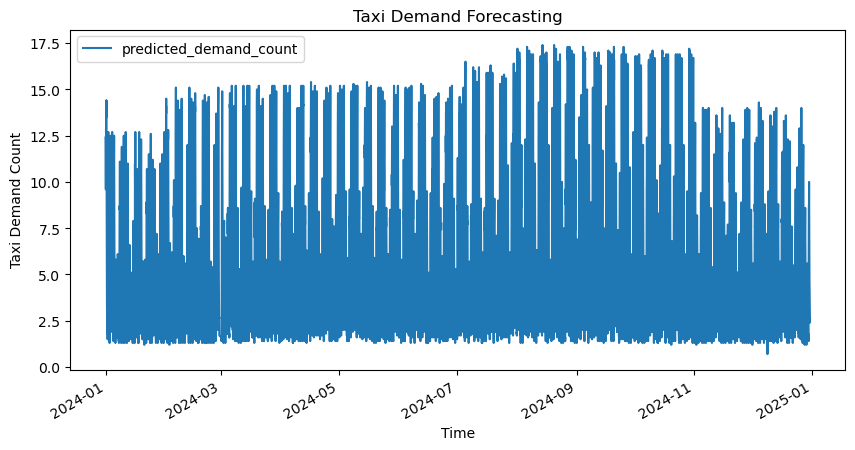

In [19]:
forecast_df.set_index('time').plot(figsize=(10, 5))
plt.xlabel('Time')
plt.ylabel('Taxi Demand Count')
plt.title('Taxi Demand Forecasting')
plt.show()

## Comparison

In [20]:
year_2023 = pd.read_csv('../data/clean/historic.csv', parse_dates=['time'])
year_2024 = forecast_df.copy()

In [21]:
for df in [year_2023, year_2024]:
    df['day_of_week'] = df['time'].dt.day_name()
    df['day_of_month'] = df['time'].dt.day
    df['hour_of_day'] = df['time'].dt.hour

In [22]:
dow_demand_2023 = year_2023.groupby('day_of_week')['demand_count'].mean()
dow_demand_2024 = year_2024.groupby('day_of_week')['predicted_demand_count'].mean()
dom_demand_2023 = year_2023.groupby('day_of_month')['demand_count'].mean()
dom_demand_2024 = year_2024.groupby('day_of_month')['predicted_demand_count'].mean()
hourly_demand_2023 = year_2023.groupby('hour_of_day')['demand_count'].mean()
hourly_demand_2024 = year_2024.groupby('hour_of_day')['predicted_demand_count'].mean()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_demand_2023 = dow_demand_2023.reindex(weekday_order)
dow_demand_2024 = dow_demand_2024.reindex(weekday_order)

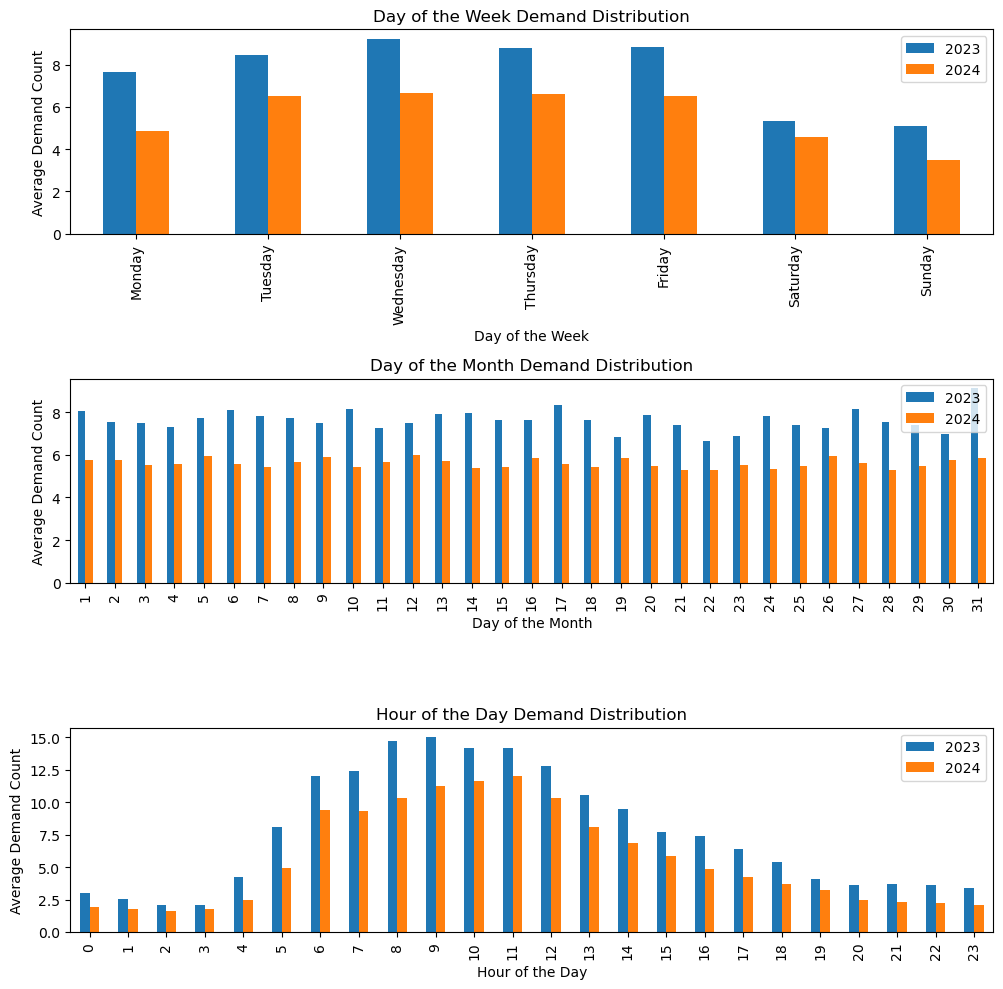

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

pd.DataFrame({'2023': dow_demand_2023, '2024': dow_demand_2024}).plot(kind='bar', ax=axes[0])
axes[0].set_title('Day of the Week Demand Distribution')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Average Demand Count')

pd.DataFrame({'2023': dom_demand_2023, '2024': dom_demand_2024}).plot(kind='bar', ax=axes[1])
axes[1].set_title('Day of the Month Demand Distribution')
axes[1].set_xlabel('Day of the Month')
axes[1].set_ylabel('Average Demand Count')

pd.DataFrame({'2023': hourly_demand_2023, '2024': hourly_demand_2024}).plot(kind='bar', ax=axes[2])
axes[2].set_title('Hour of the Day Demand Distribution')
axes[2].set_xlabel('Hour of the Day')
axes[2].set_ylabel('Average Demand Count')

plt.tight_layout()
plt.show()

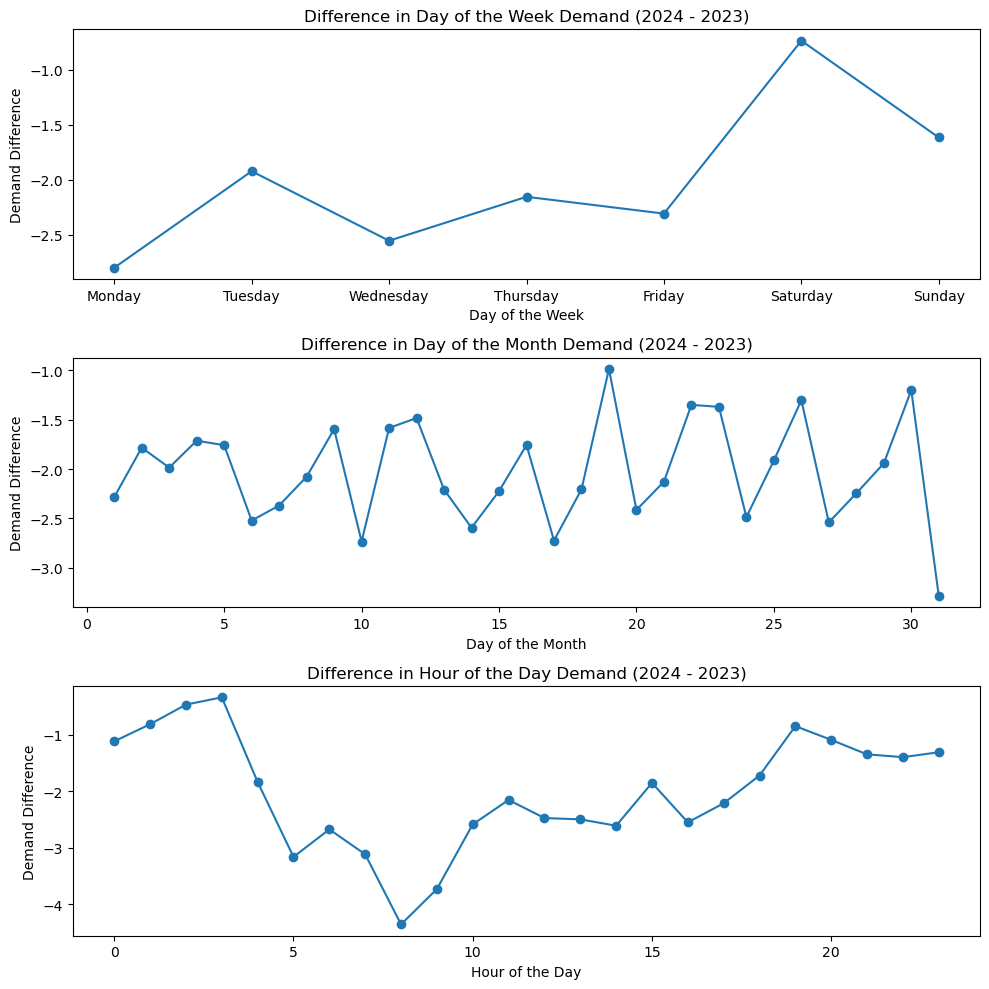

In [24]:
dow_diff = dow_demand_2024 - dow_demand_2023
dom_diff = dom_demand_2024 - dom_demand_2023
hourly_diff = hourly_demand_2024 - hourly_demand_2023

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

dow_diff.reindex(weekday_order).plot(kind='line', marker='o', ax=ax[0])
ax[0].set_title('Difference in Day of the Week Demand (2024 - 2023)')
ax[0].set_xlabel('Day of the Week')
ax[0].set_ylabel('Demand Difference')

dom_diff.plot(kind='line', marker='o', ax=ax[1])
ax[1].set_title('Difference in Day of the Month Demand (2024 - 2023)')
ax[1].set_xlabel('Day of the Month')
ax[1].set_ylabel('Demand Difference')

hourly_diff.plot(kind='line', marker='o', ax=ax[2])
ax[2].set_title('Difference in Hour of the Day Demand (2024 - 2023)')
ax[2].set_xlabel('Hour of the Day')
ax[2].set_ylabel('Demand Difference')

plt.tight_layout()
plt.show()

### Forecasted Demands in the first week of September 2024

In [25]:
september_forecast = forecast_df[(forecast_df.time > '2024-09-01') & (forecast_df.time < '2024-09-08')].reset_index(drop=True)

In [26]:
september_forecast

,time,predicted_demand_count
0,2024-09-01 01:00:00,1.6
1,2024-09-01 02:00:00,1.4
2,2024-09-01 03:00:00,1.3
3,2024-09-01 04:00:00,1.6
4,2024-09-01 05:00:00,4.0
...,...,...
162,2024-09-07 19:00:00,3.8
163,2024-09-07 20:00:00,2.7
164,2024-09-07 21:00:00,2.6
165,2024-09-07 22:00:00,2.6


In [27]:
pd.to_datetime('2024-09-01 01:00:00').day_name()

'Sunday'

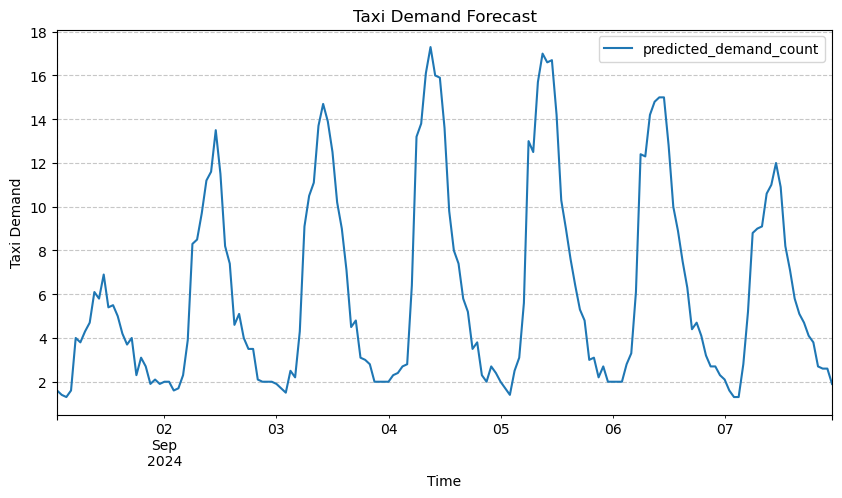

In [28]:
september_forecast.set_index('time').plot(figsize=(10,5))
plt.xlabel('Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Taxi Demand')
plt.title('Taxi Demand Forecast')
plt.show()

## Calculating Fleet Size

Reference:
- https://www.callcentrehelper.com/erlang-c-formula-example-121281.htm
- https://help.calabrio.com/doc/Content/user-guides/schedules/about-erlang-formula.htm

In [29]:
taxi_availability = 0.9   # percentage of time taxis are available for service (e.g., 90%)
max_utilization_rate = 0.85  # maximum allowed utilization rate for taxis
target_wait_prob = 0.05 # desired maximum probability that a customer will have to wait for a taxi

# avg trip duration in minutes for each week; 0 is sunday
avg_trip_duration_per_day = {
    0: 20.6,
    1: 27.8,
    2: 28.0,
    3: 28.0,
    4: 28.0,
    5: 26.9,
    6: 23.5
}

In [30]:
def calculate_service_rate(avg_trip_duration, taxi_availability, max_utilization_rate):
    """
    Calculate the effective service rate (trips per hour per taxi) based on
    average trip duration, taxi availability, and maximum utilization rate.
    """
    service_rate = (1 / avg_trip_duration) * taxi_availability * max_utilization_rate
    return service_rate

In [31]:
def erlang_c(lambda_, mu, c):
    """
    Calculate Erlang-C probability of wait for an M/M/c queue.
    """
    rho = lambda_ / (c * mu)
    if rho >= 1:
        return float("inf")  # system is unstable if rho >= 1

    # erlang-C probability (P_wait)
    numerator = (lambda_ / mu) ** c / math.factorial(c) * (c * mu / (c * mu - lambda_))
    denominator = sum((lambda_ / mu) ** k / math.factorial(k) for k in range(c)) + numerator
    P_wait = numerator / denominator

    return P_wait

In [32]:
def calculate_fleet_size(df, avg_trip_duration_per_day, taxi_availability, max_utilization_rate, target_wait_prob=0.05):
    """
    Calculate optimal fleet size for each hour based on hourly demand using an M/M/c queuing model.
    """
    fleet_sizes = []
    
    for _, row in df.iterrows():
        lambda_ = row['predicted_demand_count']  # arrival rate (demand for this hour)
        day_of_week = int(row['time'].strftime('%w')) # to find avg trip duration for that day of the week
        avg_trip_duration_hour = avg_trip_duration_per_day[day_of_week]/60
        c = 1  # start with a minimum fleet size of 1

        service_rate = calculate_service_rate(avg_trip_duration_hour, taxi_availability, max_utilization_rate)
        
        # increment fleet size until the probability of wait meets the target
        while True:
            P_wait = erlang_c(lambda_, service_rate, c)
            if P_wait <= target_wait_prob:
                fleet_sizes.append(c)
                break
            else:
                c += 1  # increase fleet size if wait probability is too high

    df['fleet_size'] = fleet_sizes
    return df

In [33]:
def plot_hourly_demand_and_fleet(df):
    """
    Plots hourly demand and fleet size on a dual-axis plot.
    """
    fig, ax1 = plt.subplots(figsize=(10, 5))

    max_y = max(df['predicted_demand_count'].max(), df['fleet_size'].max())

    ax1.plot(df['time'], df['predicted_demand_count'], color='tab:blue', label='Hourly Demand')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Hourly Demand', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(df['time'], df['fleet_size'], color='tab:orange', label='Fleet Size', linestyle='--')
    ax2.set_ylabel('Fleet Size', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    fig.suptitle('Hourly Demand vs. Minimum Fleet Size')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    ax1.set_ylim(0, max_y * 1.1)
    ax2.set_ylim(0, max_y * 1.1)
    plt.show()

In [34]:
september_forecast = calculate_fleet_size(september_forecast, 
                                          avg_trip_duration_per_day, 
                                          taxi_availability, 
                                          max_utilization_rate, 
                                          target_wait_prob)

In [35]:
september_forecast

,time,predicted_demand_count,fleet_size
0,2024-09-01 01:00:00,1.6,3
1,2024-09-01 02:00:00,1.4,3
2,2024-09-01 03:00:00,1.3,3
3,2024-09-01 04:00:00,1.6,3
4,2024-09-01 05:00:00,4.0,5
...,...,...,...
162,2024-09-07 19:00:00,3.8,6
163,2024-09-07 20:00:00,2.7,5
164,2024-09-07 21:00:00,2.6,5
165,2024-09-07 22:00:00,2.6,5


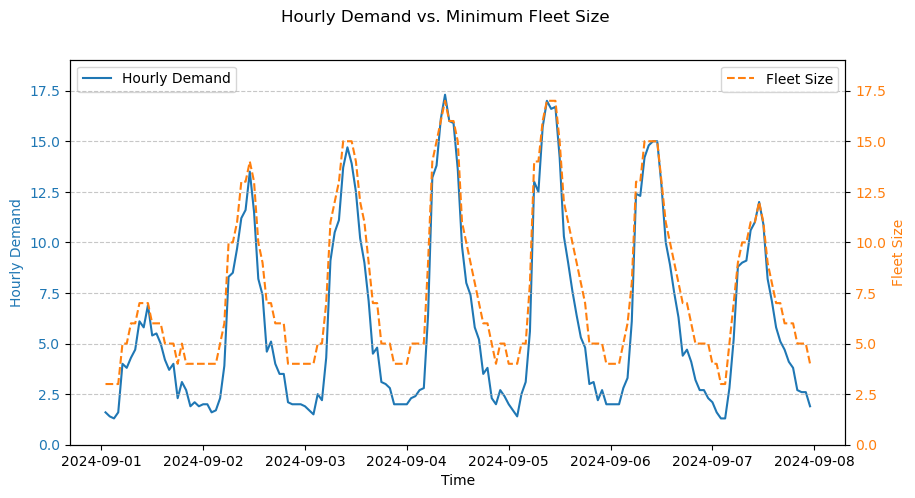

In [36]:
plot_hourly_demand_and_fleet(september_forecast)

## Exporting Forecasted demands

In [37]:
forecast_df.to_csv('../data/clean/forecasted_taxi_demand.csv', index=False)